In [1]:
import numpy as np
from celluloid import Camera 
import matplotlib.pyplot as plt
from matplotlib import rc
import os.path as path
import wget
import sympy as sp
from scipy import integrate

# 0.1 Colisiones 2D de duración finita (juguemos billar)

## 1.

La constante K es el coeficiente de deformación que actúa en cada uno de los objetos del sistema. Para un coeficiente mayor, se requiere una mayor fuerza para modificar la forma del esférica de la bola. El significado físico es la resistencia a la deformación esférica tridimensional debida al material del que se encuentra hecha la bola de billar.
La fuerza es conservativa

In [34]:
class Particle():

    def __init__(self,r0,v0,a0,rd,t,m,Id):

        self.r = r0
        self.v = v0
        self.a = a0
        self.dt=t[1]-t[0]

        self.rad = rd
        self.m = m
        self.Id = Id

        self.k = m*(np.sum(v0**2)/2)

        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        self.kVector = np.zeros(len(t))
   
        
    def SetPosition(self,i,r):
        self.rVector[i]=r
    
    def SetVelocity(self,i,v):
        self.vVector[i]=v
    
    def SetAceleration(self,i,a):
        self.aVector[i] = a
        
    def SetKinetic(self,i,k):
        self.kVector[i]=k
        
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector
    
    def GetVelocityVector(self):
        return self.vVector
        
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetAcelerationVector(self):
        return self.aVector
    
    def GetRAcelerationVector(self):
        return self.RaVector
    
    def GetRad(self):
        return self.rad
  
    def Evolution(self,i):

        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetAceleration(i,self.a)
        
        self.k = self.m*(np.sum(self.v**2)/2)
        self.SetK(i, self.k)
        
        self.v+=self.a*self.dt
        self.r+=self.v*self.dt
        
        self.F=0.
        self.a=np.zeros(2)
                        
    def CheckWallLimits(self,limits,dim,e):        
        for i in range(dim):
            if  self.v[i]>=0 and self.r[i] + self.rad > limits[i]:
                self.v[i] = - self.v[i]*e
            elif self.v[i]<=0 and self.r[i] - self.rad < - limits[i]:
                self.v[i] = - self.v[i]*e
                
    def ReduceSize(self,factor):     

        self.RrVector = np.array([self.rVector[0]])
        self.RvVector = np.array([self.vVector[0]])
        self.RkVector = np.array([self.kVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                self.RkVector = np.vstack([self.RkVector,self.kVector[i]])
    def energyk(self, particulas):
        Ek = 0
        for particula in particulas:
            Eo=particula.m*(la.norm(particula.v))**2
            Ek= Eo + Ek
        return Ek
    
    def energyU(self, particulas, g=9.8):
        Eu= 0
        for particula in particulas:
            Eo=particula.m*((np.abs(particula.r[1])))*g
            Eu= Eo+Eu
        return Eu
    
                
    def golpe(self,Particles):

        Forcevector = np.zeros(len(self.a))

        #for i in Particles:
        #if self.Id != i.Id:
        p = np.sum((self.r - Particles.r)[:]**2)**(1/2)
        if p < Particles.GetRad() + self.GetRad():
            Forcevector[0] += (100*p**2)*(self.r - Particles.r)[0]
            Forcevector[1] += (100*p**2)*(self.r - Particles.r)[1]
        
        self.a = (Forcevector/self.m)

In [35]:
def ReduceTime(t,factor,parts): 
    for i in range(len(parts)):
        parts[i].ReduceSize(factor)
       
    time = []    
    for j in range(len(t)):
        if j%factor == 0:
            time.append(t[j])            
    return np.array(time)

In [36]:
def Interactions(S,It):
    S[It].golpe(S)   
    return S

In [37]:
Bola1 = Particle(np.array([-10.,1.]), np.array([20.,0.]), np.array([0.,0.]), 2, np.arange(0,10+1e-4,1e-4), 1, 0)
Bola2 = Particle(np.array([0.,-1.6]), np.array([0.,0.]), np.array([0.,0.]), 2, np.arange(0,10+1e-4,1e-4), 1, 1)
Bola3 = Particle(np.array([-15.,-15.]), np.array([0.,0.]), np.array([0.,0.]), 2, np.arange(0,10+1e-4,1e-4), 1, 2)

P=np.array([Bola1,Bola2,Bola3])
limits1=[20,20]
C=len(P)

In [41]:
t=np.arange(0,10+1e-4,1e-4)
k=np.zeros(len(t))
U=np.zeros(len(t))
def RunSimulationP(t,P, Limits):
    for i in tqdm(range(len(t))):
        for j in range(len(P)):
            for c in range(len(P)):
                if j != c:
                    P[j].golpe(P[c])
            P[j].CheckWallLimits(Limits,dim = 2,e = 1)
            P[j].Evolution(i)
            P[j].a = 0
        Eki=P[0].energia_del_sistema_k(P)
        EUi=P[0].energia_del_sistema_U(P)
        k[i]=Eki
        U[i]=EUi
    return P

In [43]:
Limits = [20,20]
A=RunSimulationP(t,P, Limits)
ret=ReduceTime(t,100,A)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
camera = Camera(fig)

colors=['r','b','g']
labels=['Bola 1','Bola 2','Bola 3']
for i in tqdm(range(len(ret))):   
    for p in range(len(A)):
        x = A[p].GetRPositionVector()[i,0]
        y = A[p].GetRPositionVector()[i,1]
        
        vx = A[p].GetRVelocityVector()[i,0]
        vy = A[p].GetRVelocityVector()[i,1]
        
        circle = plt.Circle( (x,y), A[p].GetRad(), color=colors[p], fill=True)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    camera.snap()
    
animation = camera.animate(interval=2)
animation.save('Carambola.gif')


  0%|                                               | 0/100001 [00:00<?, ?it/s]


AttributeError: 'Particle' object has no attribute 'SetK'

/home/juan/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


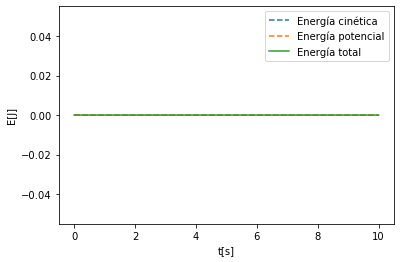

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure()
plt.plot(t,k,'--',label='Energía cinética')
plt.plot(t,U,'--',label='Energía potencial')
plt.plot(t,k+U,'-',label='Energía total')
plt.xlabel('t[s]')
plt.ylabel('E[J]')
plt.legend()
plt.show()
plt.savefig('Energ.png')

# 0.2 Tiempo libre medio
## 1.

In [2]:
Dir = "Data/"
if not path.exists(Dir):
    !mkdir Data

In [3]:
file = "Data/EnergiaPotencialGas2D.dat"
url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt"
if not path.exists(file):
    Path_=wget.download(url,file)
    print("Descargado")
else:
    Path_=file

100% [.......................................................] 400000 / 400000Descargado


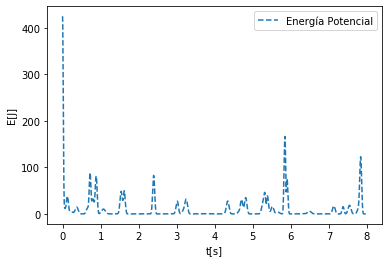

In [4]:
data = np.loadtxt(Path_)

fig = plt.plot(data[:,0],data[:,1],linestyle='--', label = "Energía Potencial")
fig = plt.ylabel("E[J]")
fig = plt.xlabel("t[s]")
fig = plt.legend()

In [5]:

f = data[:,1]-np.mean(data[:,1])

fft = np.fft.fft(f)

In [6]:

Npoints = len(f)
Frecuencias = np.fft.fftfreq(Npoints,1)
ffta = np.abs(fft)

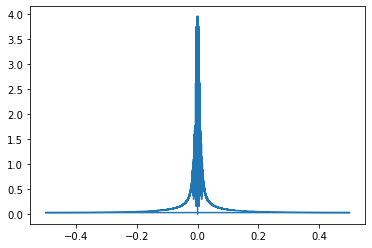

In [7]:
plt.plot(Frecuencias, np.abs(fft/Npoints))

In [8]:
ii = fft != np.max(fft)
fft[ii]= 0

In [9]:
NewFreq = np.arange(len(fft))

In [10]:
re = np.fft.irfft(fft)

In [11]:
T= 1/np.max(np.abs(fft/Npoints))

print("Tiempo libre medio = ",T)

Tiempo libre medio =  0.25306746748436315


In [12]:
X = np.linspace(np.min(data[:,0]),np.max(data[:,0]),len(re))

In [13]:
X

array([0.00000000e+00, 5.00031256e-04, 1.00006251e-03, ...,
       7.99799994e+00, 7.99849997e+00, 7.99900000e+00])

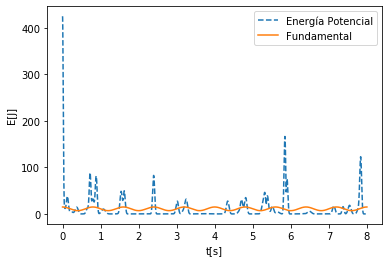

In [14]:
data = np.loadtxt(Path_)


fig = plt.plot(data[:,0],data[:,1],linestyle='--', label = "Energía Potencial")
fig = plt.plot(X, re+np.mean(data[:,1]), label = "Fundamental")

fig = plt.ylabel("E[J]")
fig = plt.xlabel("t[s]")
fig = plt.legend()

# 0.3 Termodinámica

## 1.

## 2. Cython

In [15]:
!g++ Cython.cpp -o Cython

In [16]:
!./Cython

0x563ff31b0eb8


In [17]:
data = np.loadtxt("Data/DerivadaCentral.txt")

Text(0.5, 1.0, 'Derivada central de $e^{-x^2}$')

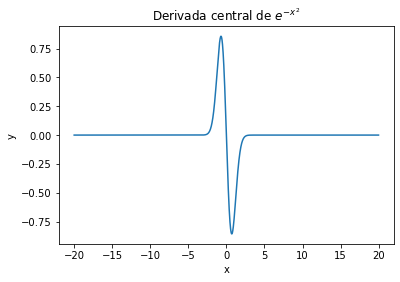

In [18]:
plt.plot(data[:,0],data[:,1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Derivada central de $e^{-x^2}$")